# Oral Health Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re

---

## load NHANES data tables

In [2]:
DEMO_C = pd.read_table('../data/2003-2004/DEMO_C_demographics.tsv')
OHXDEN_C = pd.read_table('../data/2003-2004/OHXDEN_C_dentition_exam.tsv')
OHXPRL_C = pd.read_table('../data/2003-2004/OHXPRL_C_perio-lower_exam.tsv')
OHXPRU_C = pd.read_table('../data/2003-2004/OHXPRU_C_perio-upper_exam.tsv')

In [3]:
print('DEMO_C.shape (demographics):', DEMO_C.shape)
print('OHXDEN_C.shape (dentition):', OHXDEN_C.shape)
print('OHXPRL_C.shape (lower perio):', OHXPRL_C.shape)
print('OHXPRU_C.shape (upper perio):', OHXPRU_C.shape)

DEMO_C.shape (demographics): (10122, 44)
OHXDEN_C.shape (dentition): (8847, 149)
OHXPRL_C.shape (lower perio): (6718, 171)
OHXPRU_C.shape (upper perio): (6718, 171)


---

## get tooth columns and loss attachement columns from dentition and perio (lower and upper) tables  
These columns will be used for subsetting the data (below)

In [4]:
dent_tooth_regex = re.compile(
    r'OHX[0-9]{2}TC'
)
temp = map(
        lambda x: 
            dent_tooth_regex.match(x).group() if dent_tooth_regex.match(x) else None, 
            OHXDEN_C.columns   
        )
dentition_tooth_cols = [x for x in temp if x is not None]
(dentition_tooth_cols[:5], dentition_tooth_cols[-5:]) # check head and tail of list

(['OHX08TC', 'OHX07TC', 'OHX06TC', 'OHX05TC', 'OHX04TC'],
 ['OHX28TC', 'OHX29TC', 'OHX30TC', 'OHX31TC', 'OHX32TC'])

In [5]:
perio_cal_regex = re.compile(
    r'OHD[0-9]{2}(LAD|LAM|LAS)'
)
temp = map(
    lambda x: 
           perio_cal_regex.match(x).group() if perio_cal_regex.match(x) else None, 
           OHXPRL_C.columns
    )
perio_cal_lower_cols = [x for x in temp if x is not None]
print('number of lower perio cols:', len(perio_cal_lower_cols))
(perio_cal_lower_cols[:5], perio_cal_lower_cols[-5:]) # check head and tail of list

number of lower perio cols: 42


(['OHD18LAM', 'OHD18LAS', 'OHD18LAD', 'OHD19LAM', 'OHD19LAS'],
 ['OHD26LAS', 'OHD26LAD', 'OHD25LAM', 'OHD25LAS', 'OHD25LAD'])

In [6]:
perio_cal_regex = re.compile(
    r'OHD[0-9]{2}(LAD|LAM|LAS)'
)
temp = map(
    lambda x: 
           perio_cal_regex.match(x).group() if perio_cal_regex.match(x) else None, 
           OHXPRU_C.columns
    )
perio_cal_upper_cols = [x for x in temp if x is not None]
print('number of upper perio cols:', len(perio_cal_upper_cols))
(perio_cal_upper_cols[:5], perio_cal_upper_cols[-5:]) # check head and tail of list

number of upper perio cols: 42


(['OHD02LAM', 'OHD02LAS', 'OHD02LAD', 'OHD03LAM', 'OHD03LAS'],
 ['OHD10LAS', 'OHD10LAD', 'OHD09LAM', 'OHD09LAS', 'OHD09LAD'])

combine lower and upper perio cols

In [7]:
perio_cal_cols = perio_cal_lower_cols + perio_cal_upper_cols
print('number of perio cols:', len(perio_cal_cols))
(perio_cal_cols[:5], perio_cal_cols[-5:]) # check head and tail

number of perio cols: 84


(['OHD18LAM', 'OHD18LAS', 'OHD18LAD', 'OHD19LAM', 'OHD19LAS'],
 ['OHD10LAS', 'OHD10LAD', 'OHD09LAM', 'OHD09LAS', 'OHD09LAD'])

---

## create data subsets for patients 18 and older  
* For demographics, only include 18 and older.
* For periodontal, only include patients from demographics subset 
* For the dentition, only include patients from demographics subset and those that have a periodontal information.
* Finally, subset demographic data for those with perio records.

subset demographics to 18 and older

In [8]:
demog_df = DEMO_C[DEMO_C.RIDAGEYR > 17].copy()
demog_df.shape

(5620, 44)

subset perio data to those in the demographics table

In [9]:
perio_lower_df = OHXPRL_C[OHXPRL_C.SEQN.isin(demog_df.SEQN)]
perio_lower_df.shape

(5303, 171)

In [10]:
perio_upper_df = OHXPRU_C[OHXPRU_C.SEQN.isin(demog_df.SEQN)]
perio_upper_df.shape

(5303, 171)

Verify the `SENQ` in perio upper and perio lower are the same. Answer should be `False`

In [11]:
False in list(OHXPRL_C.SEQN == OHXPRU_C.SEQN)

False

concat lower and upper perio data

In [12]:
perio_cal_df = pd.merge(perio_lower_df, perio_upper_df, how='inner', on='SEQN')
perio_cal_df.shape

(5303, 341)

subset dentition table to those in the perio table

In [13]:
dentition_df = OHXDEN_C[OHXDEN_C.SEQN.isin(perio_cal_df.SEQN)].reset_index(drop=True)
dentition_df.shape

(5303, 149)

now, trim down the demographics data to those with perio data  
since demographic table has 5620 records (above) and the perio has 5303 records, some demographic records do not have matches in the perio table

In [14]:
demog_df = demog_df[demog_df.SEQN.isin(perio_cal_df.SEQN)].reset_index(drop=True)
demog_df.shape

(5303, 44)

---

## subset dentition and perio columns to specific tooth columns

In [15]:
dentition_df = dentition_df[['SEQN'] + dentition_tooth_cols] # remember to include the SEQN column
dentition_df.shape

(5303, 33)

In [16]:
perio_cal_df = perio_cal_df[['SEQN'] + perio_cal_cols] # remember to include the SEQN column
perio_cal_df.shape

(5303, 85)

---

## calculate number of teeth for each dentition record  

In [17]:
def calculate_num_teeth(dentition_row):
    teeth = [
        tooth for tooth in dentition_row
        if tooth == 'Permanent tooth (succedaneous)' or tooth == 'Primary tooth (deciduous)'
    ]
    return len(teeth)

In [18]:
dentition_df['num_teeth'] = dentition_df.apply(lambda row: calculate_num_teeth(row), axis=1)

add number of teeth data to perio data

In [19]:
perio_cal_df = pd.merge(perio_cal_df, dentition_df[['SEQN', 'num_teeth']], how='left', on='SEQN')

---

## calculate number of teeth with CAL >=3mm, >=4mm, >=5mm  

create a dict mapping each CAL measurement to a tooth.  
e.g., OHD18LAM maps to OHD18 (i.e., tooth 18)

In [20]:
# to associate CAL with tooth, create a map for each tooth CAL group
# note: groups are based on the first 5 chars in CAL column name (e.g., OHX02)
tooth_cal_dict = {
    f'{k}TC':list(g) for k, g in itertools.groupby(perio_cal_cols, key=lambda col: col[:5])
}

In [21]:
def calculate_num_CAL_measurement(perio_cal_row, measurement, tooth_cal_dict):
    teeth_measurements = [] # list to hold teeth that have >= measurement

    # get each tooth and the CAL measurement fields for that tooth
    for tooth_key, tooth_cal_fields in tooth_cal_dict.items():
        # now get the CAL measurement for the field
        for field in tooth_cal_fields:
            cal = perio_cal_row[field] # note: perio_cal_row is pandas series
            
            # if the CAL is >= the measurement add the tooth to teeth_measurements
            # break out of loop since there no need to check more fields
            if pd.notnull(cal) and cal < 99 and cal >= measurement:
                teeth_measurements.append(tooth_key)
                break
    return len(teeth_measurements) # return number of teeth >= measurement

add number and percentage of teeth with CAL >= measurement

In [22]:
# teeth with CAL >= 3mm
perio_cal_df['num_teeth_gte_3'] = \
    perio_cal_df.apply(lambda row: calculate_num_CAL_measurement(row, 3, tooth_cal_dict), axis=1)
perio_cal_df['pct_teeth_gte_3'] = \
    np.where(perio_cal_df.num_teeth > 0, round(perio_cal_df.num_teeth_gte_3/perio_cal_df.num_teeth, 2), 0)

# teeth with CAL >= 4mm
perio_cal_df['num_teeth_gte_4'] = \
    perio_cal_df.apply(lambda row: calculate_num_CAL_measurement(row, 4, tooth_cal_dict), axis=1)
perio_cal_df['pct_teeth_gte_4'] = \
    np.where(perio_cal_df.num_teeth > 0, round(perio_cal_df.num_teeth_gte_4/perio_cal_df.num_teeth, 2), 0)

# teeth with CAL >= 5mm
perio_cal_df['num_teeth_gte_5'] = \
    perio_cal_df.apply(lambda row: calculate_num_CAL_measurement(row, 5, tooth_cal_dict), axis=1)
perio_cal_df['pct_teeth_gte_5'] = \
    np.where(perio_cal_df.num_teeth > 0, round(perio_cal_df.num_teeth_gte_5/perio_cal_df.num_teeth, 2), 0)

In [23]:
perio_cal_df.head()

,SEQN,OHD18LAM,OHD18LAS,OHD18LAD,OHD19LAM,OHD19LAS,OHD19LAD,OHD20LAM,OHD20LAS,OHD20LAD,...,OHD09LAM,OHD09LAS,OHD09LAD,num_teeth,num_teeth_gte_3,pct_teeth_gte_3,num_teeth_gte_4,pct_teeth_gte_4,num_teeth_gte_5,pct_teeth_gte_5
0,21005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,28,0,0.00,0,0.00,0,0.00
1,21009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24,0,0.00,0,0.00,0,0.00
2,21010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,19,4,0.21,3,0.16,1,0.05
3,21012,99.0,99.0,99.0,6.0,6.0,7.0,4.0,2.0,3.0,...,0.0,6.0,3.0,19,10,0.53,10,0.53,7,0.37
4,21015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25,0,0.00,0,0.00,0,0.00


## save output

In [24]:
perio_cal_df.pct_teeth_gte_3
save_df = pd.merge(
    demog_df[['SEQN', 'RIDAGEYR', 'RIAGENDR', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA']],
    perio_cal_df[['SEQN', 'num_teeth', 'num_teeth_gte_3', 'pct_teeth_gte_3', 'num_teeth_gte_4', 'pct_teeth_gte_4', 'num_teeth_gte_5', 'pct_teeth_gte_5']],
    how='inner',
    on='SEQN'
)
save_df.shape

(5303, 14)

In [25]:
save_df.head()

,SEQN,RIDAGEYR,RIAGENDR,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,num_teeth,num_teeth_gte_3,pct_teeth_gte_3,num_teeth_gte_4,pct_teeth_gte_4,num_teeth_gte_5,pct_teeth_gte_5
0,21005,19,Male,5512.320949,5824.782465,2,39,28,0,0.00,0,0.00,0,0.00
1,21009,55,Male,97593.678977,97731.727244,2,31,24,0,0.00,0,0.00,0,0.00
2,21010,52,Female,39599.362689,43286.576474,1,29,19,4,0.21,3,0.16,1,0.05
3,21012,63,Male,12629.440480,12947.338142,2,33,19,10,0.53,10,0.53,7,0.37
4,21015,83,Male,17625.875727,19994.159857,2,33,25,0,0.00,0,0.00,0,0.00


In [ ]:
save_df.to_csv('../data/2003-2004/output/patient_tooth_CAL

## plot results

**help function for determining age groups**

In [108]:
def get_age_group(age):
    age_group = ''
    if age >= 18 and age <= 25:
        age_group = '18-25'
    elif age >= 26 and age <= 35:
        age_group = '26-35'
    elif age >= 36 and age <= 45:
        age_group = '36-45'
    elif age >= 46 and age <= 55:
        age_group = '46-55'
    elif age >= 56 and age <= 65:
        age_group = '56-65'
    elif age >= 66 and age <= 75:
        age_group = '66-75'
    else:
        age_group = '76+'
    
    return age_group

set some default figure figures

In [27]:
%matplotlib inline
sns.set_theme(
    context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None
)

In [109]:
summary_df = pd.merge(
    demog_df[['SEQN', 'RIDAGEYR', 'RIAGENDR']], 
    perio_cal_df[['SEQN', 'num_teeth', 'num_teeth_gte_3', 'pct_teeth_gte_3', 'num_teeth_gte_4', 'pct_teeth_gte_4', 'num_teeth_gte_5', 'pct_teeth_gte_5']], 
    on='SEQN', 
    how='inner'
)
summary_df = summary_df.rename(
    columns={
        'RIDAGEYR':'age', 
        'RIAGENDR': 'gender', 
        'num_teeth_gte_3':
        '# CAL >= 3', 
        'pct_teeth_gte_3': 
        '% CAL >= 3',
        'num_teeth_gte_4':
        '# CAL >= 4', 
        'pct_teeth_gte_4': 
        '% CAL >= 4',
        'num_teeth_gte_5':
        '# CAL >= 5', 
        'pct_teeth_gte_5': 
        '% CAL >= 5'
    }
)
summary_df['age group'] = summary_df['age'].map(get_age_group)

## age and gender distribution

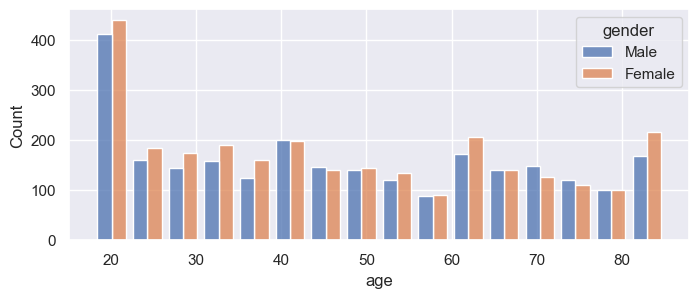

In [132]:
plt.figure(figsize=(8,3))
sns.histplot(data=summary_df, x='age', hue='gender', multiple="dodge", shrink=.8)
plt.savefig('../figures/age-gender-distribution.png', dpi=300)
plt.show()

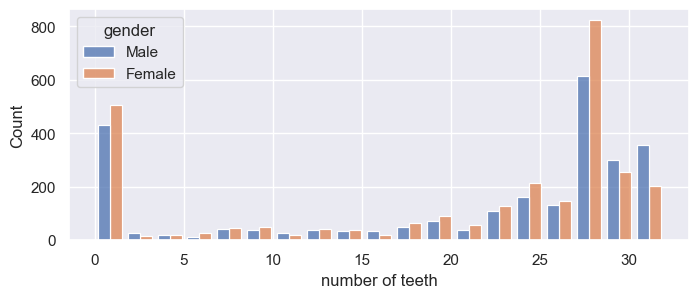

In [133]:
plt.figure(figsize=(8,3))
ax = sns.histplot(data=summary_df, x='num_teeth', hue='gender', multiple="dodge", shrink=.8)
ax.set_xlabel('number of teeth')

plt.savefig('../figures/age-num_teeth-distribution.png', dpi=300)
plt.show()

## plot age by pct_teeth >= CAL

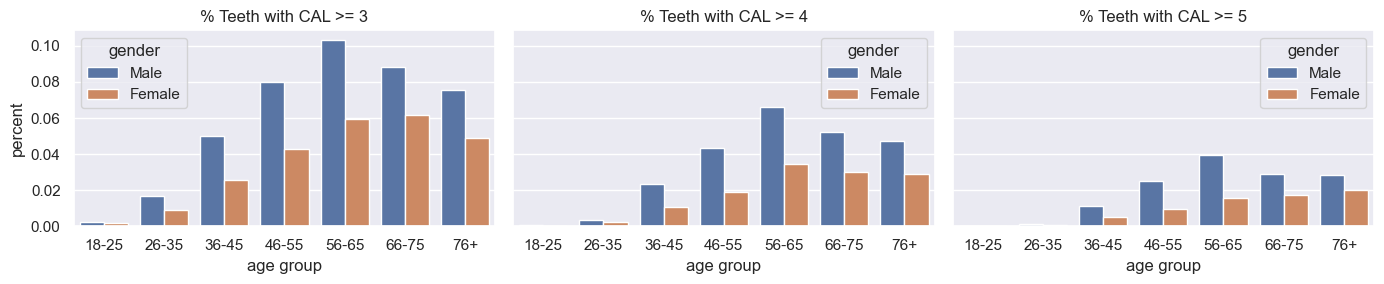

In [134]:
# order_ = ['76+', '66-75', '56-65', '46-55', '36-45', '26-35', '18-25'] 
order_ = ['18-25', '26-35','36-45','46-55','56-65', '66-75', '76+']

fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharex=True, sharey=True, tight_layout=True)

sns.barplot(data=summary_df, x='age group', y='% CAL >= 3', order=order_, errorbar=None, hue='gender', estimator='mean', ax=axs[0])
axs[0].set_title('% Teeth with CAL >= 3')

sns.barplot(data=summary_df, x='age group', y='% CAL >= 4', order=order_, errorbar=None, hue='gender', estimator='mean', ax=axs[1])
axs[1].set_title('% Teeth with CAL >= 4')

sns.barplot(data=summary_df, x='age group', y='% CAL >= 5', order=order_, errorbar=None, hue='gender', estimator='mean', ax=axs[2])
axs[2].set_title('% Teeth with CAL >= 5')

axs[0].set_xlabel('age group')
axs[1].set_xlabel('age group')
axs[2].set_xlabel('age group')

axs[0].set_ylabel('percent')

plt.savefig('../figures/age-pct_teeth_CAL-distribution.png', dpi=300)
plt.show()